#Convolutional Neural Network for identifying 3 most commonly mistaken species of gulls in Poland - *Larus argentatus*, *Larus cachinnans* and *Larus michachellis*

<table align="center">
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/bazylip/gulls-ai-guide/blob/master/gulls_guide.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/bazylip/gulls-ai-guide/blob/master/gulls_guide.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

In [18]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

import matplotlib.pyplot as plt
import numpy as np
import random
import re
from PIL import Image, ImageOps, ImageFile
from io import BytesIO
from tqdm import tqdm
from bs4 import BeautifulSoup
import requests
import collections

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

Download images from [Gull Research website](http://www.gull-research.org/)

In [6]:
urls = ['http://www.gull-research.org/hg/hg1cy/', 'http://www.gull-research.org/hg/hg2cy/',
        'http://www.gull-research.org/hg/hg3cy/', 'http://www.gull-research.org/hg/hg4cy/',
        'http://www.gull-research.org/hg/hg5cy/']
image_urls = collections.defaultdict(list)

def list_files(url, ext='html'):
    page = requests.get(url).text
    soup = bs(page, 'html.parser')
    return [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
  
def get_all_image_urls(site):
    response = requests.get(site)

    soup = BeautifulSoup(response.text, 'html.parser')
    img_tags = soup.find_all('img')

    urls = [img['src'] for img in img_tags]
    image_urls = []
    for url in urls:
        filename = re.search(r'/([\w_-]+[.](jpg|png|JPG|PNG))$', url)
        if not filename:
            continue
        if 'http' not in url:
            # sometimes an image source can be relative 
            # if it is provide the base url which also happens 
            # to be the site variable atm.
            site_level_below = '/'.join(site.split('/')[:-2])
            url_with_no_dots = '/'.join(url.split('/')[1:]) 
            url = f"{site_level_below}/{url_with_no_dots}"
        image_urls.append(url)
    return image_urls

for age, url in enumerate(urls):
  for site in list_files(url):
    urls_from_site = get_all_image_urls(site)
    
    if urls_from_site is not None:
      for image_url in urls_from_site:
        image_urls[age+1].append(image_url)



In [7]:
for age in image_urls.keys():
  print(f"Images for age {age}: {len(image_urls[age])}")

Images for age 1: 1438
Images for age 2: 1802
Images for age 3: 1258
Images for age 4: 1201
Images for age 5: 1731


Download the images and turn them into np.array

In [20]:
size = (400, 400)
images_and_labels = []

ImageFile.LOAD_TRUNCATED_IMAGES = True

for age in image_urls.keys():
  for url in image_urls[age]:
    try:
      response = requests.get(url)
      img = Image.open(BytesIO(response.content))
      square_size = max(img.size)

      img_square = ImageOps.fit(img, (square_size, square_size), Image.ANTIALIAS)
      img_resized = img_square.resize(size, Image.ANTIALIAS)

      img_array = np.asarray(img_resized)
      images_and_labels.append((img_array, age))
    except:
      pass


Now divide the images and labels into train set and test set

In [34]:
random.shuffle(images_and_labels)
train_set_size = 1000

train_images = [tup[0] for tup in images_and_labels][:-train_set_size]
train_labels = [tup[1] for tup in images_and_labels][:-train_set_size]

test_images = [tup[0] for tup in images_and_labels][-train_set_size:]
test_labels = [tup[1] for tup in images_and_labels][-train_set_size:]

Let's see an example picture from the dataset

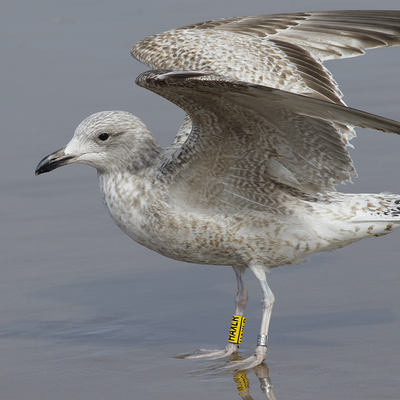

2


In [35]:
def numpy2pil(np_array):
    assert_msg = 'Input shall be a HxWx3 ndarray'
    assert isinstance(np_array, np.ndarray), assert_msg
    assert len(np_array.shape) == 3, assert_msg
    assert np_array.shape[2] == 3, assert_msg

    img = Image.fromarray(np_array, 'RGB')
    return img

display(numpy2pil(train_images[0]))
print(train_labels[0])